# Table of Contents
1. [Introduction](#introduction)
2. [Retrieve jobs from Ceph and map to JSON dataframe](#display-jobs-in-dataframe)
3. [Inspection Run Results](#inspection)
3. [Identify parameters that are not constant](#non-constant-parameters)
4. [Visualizations](#plots)
4. [Behavior of categorical data](#seperate-left-and-right)
5. [Further analysis](#descriptive-analysis)


## Introduction <a name="introduction"></a>

**Overview**

The purpose of this notebook is to further analyze the statistics regarding the inspection results produced by Amun (https://github.com/thoth-station/amun-api). The conclusions in this notebook are important to identify how the inspection jobs performed in the environment and what trends in data are present. Understanding the inspection job results can help identify the environment needed to perform the tests for the AI stacks. 



## Retrieve jobs from Ceph and map to JSON dataframe <a name="display-jobs-in-dataframe"></a>

The following section retrieves the data from Ceph storage and organizes it into a JSON data frame as shown in Amun InspectionRun Analysis.

In [1]:
%env THOTH_DEPLOYMENT_NAME     thoth-core-upshift-stage
%env THOTH_CEPH_BUCKET         thoth
%env THOTH_CEPH_BUCKET_PREFIX  data/thoth
%env THOTH_S3_ENDPOINT_URL     https://s3.upshift.redhat.com/

env: THOTH_DEPLOYMENT_NAME=thoth-core-upshift-stage
env: THOTH_CEPH_BUCKET=thoth
env: THOTH_CEPH_BUCKET_PREFIX=data/thoth
env: THOTH_S3_ENDPOINT_URL=https://s3.upshift.redhat.com/


In [2]:
import pandas as pd
from pandas.io.json import json_normalize
from pandas_profiling import ProfileReport as profile
from typing import List, Union
from thoth.storages import InspectionResultsStore
from thoth.lab import inspection
from thoth.lab import underscore
from pandas.plotting import lag_plot
import seaborn as sns
from scipy import stats


pd.set_option("max_colwidth", 800)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import plotly.offline as py

In [4]:
inspection_store = InspectionResultsStore(region="eu-central-1")
inspection_store.connect()

In [5]:
inspection_results = []

for document_id, document in inspection_store.iterate_results():
    # pop build logs to save some memory (not necessary for now)
    document["build_log"] = None

    inspection_results.append(document)

In [6]:
df_original = json_normalize(inspection_results, sep = ".")

In [65]:
#This is original data from the inspection results store. Columns are parameters and each row is an Inspection Result.
df_original.head()

build_log                     created                inspection_id  \
0      None  2019-05-10T12:25:54.606897  inspection-004187facf477500   
1      None  2019-05-10T03:07:00.369512  inspection-005715b831d9f85d   
2      None  2019-05-10T12:26:50.010847  inspection-018f61622a4d1b47   
3      None  2019-05-10T12:25:46.359680  inspection-023cd5c1a2d105b4   
4      None  2019-05-10T12:26:58.437661  inspection-036425d585e8192d   

   job_log.exit_code  job_log.hwinfo.cpu.has_3dnow  \
0                  0                         False   
1                  0                         False   
2                  0                         False   
3                  0                         False   
4                  0                         False   

   job_log.hwinfo.cpu.has_3dnowext job_log.hwinfo.cpu.has_Altivec  \
0                            False                           None   
1                            False                           None   
2                            False                           None   
3                            False                           None   
4                            False                           None   

  job_log.hwinfo.cpu.has_f00f_bug job_log.hwinfo.cpu.has_fdiv_bug  \
0                            None                            None   
1                            None                            None   
2                            None                            None   
3                            None                            None   
4                            None                            None   

   job_log.hwinfo.cpu.has_mmx  job_log.hwinfo.cpu.has_sse  \
0                        True                        True   
1                        True                        True   
2                        True                        True   
3                        True                        True   
4                        True                        True   

   job_log.hwinfo.cpu.has_sse2  job_log.hwinfo.cpu.has_sse3  \
0                         True                         True   
1                         True                         True   
2                         True                         True   
3                         True                         True   
4                         True                         True   

   job_log.hwinfo.cpu.has_ssse3 job_log.hwinfo.cpu.is_32bit  \
0                          True                        None   
1                          True                        None   
2                          True                        None   
3                          True                        None   
4                          True                        None   

  job_log.hwinfo.cpu.is_64bit  job_log.hwinfo.cpu.is_AMD  \
0                        None                      False   
1                        None                      False   
2                        None                      False   
3                        None                      False   
4                        None                      False   

   job_log.hwinfo.cpu.is_AMD64 job_log.hwinfo.cpu.is_Alpha  \
0                        False                        None   
1                        False                        None   
2                        False                        None   
3                        False                        None   
4                        False                        None   

   job_log.hwinfo.cpu.is_Athlon64  job_log.hwinfo.cpu.is_AthlonHX  \
0                           False                           False   
1                           False                           False   
2                           False                           False   
3                           False                           False   
4                           False                           False   

   job_log.hwinfo.cpu.is_AthlonK6  job_log.hwinfo.cpu.is_AthlonK6_2  \
0                           False                             False  

In [8]:
df_duration = inspection.process_inspection_results(
    inspection_results,
    exclude=["build_log", "created", "inspection_id"],
    apply=[("created|started_at|finished_at", pd.to_datetime)],
)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [66]:
#This data frame displays the data with the build and job duration columns. 
df_duration.head()

index build_log                    created                inspection_id  \
0      0      None 2019-05-10 12:25:54.606897  inspection-004187facf477500   
1      1      None 2019-05-10 03:07:00.369512  inspection-005715b831d9f85d   
2      2      None 2019-05-10 12:26:50.010847  inspection-018f61622a4d1b47   
3      3      None 2019-05-10 12:25:46.359680  inspection-023cd5c1a2d105b4   
4      4      None 2019-05-10 12:26:58.437661  inspection-036425d585e8192d   

   job_log__hwinfo__cpu__is_XEON  job_log__hwinfo__cpu__is_Xeon  \
0                           True                           True   
1                           True                           True   
2                           True                           True   
3                           True                           True   
4                           True                           True   

   job_log__hwinfo__cpu__ncpus job_log__hwinfo__platform__architecture  \
0                           64                               [64bit, ]   
1                           64                               [64bit, ]   
2                           32                               [64bit, ]   
3                           32                               [64bit, ]   
4                           32                               [64bit, ]   

     job_log__hwinfo__platform__node  \
0  inspection-004187facf477500-g9n26   
1  inspection-005715b831d9f85d-6v5kq   
2  inspection-018f61622a4d1b47-skcjl   
3  inspection-023cd5c1a2d105b4-2zbsn   
4  inspection-036425d585e8192d-6k75d   

                                job_log__hwinfo__platform__platform  \
0  Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core   
1  Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core   
2  Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core   
3  Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core   
4  Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core   

  job_log__hwinfo__platform__release   job_log__hwinfo__platform__version  \
0          3.10.0-862.9.1.el7.x86_64  #1 SMP Wed Jun 27 04:30:39 EDT 2018   
1          3.10.0-862.9.1.el7.x86_64  #1 SMP Wed Jun 27 04:30:39 EDT 2018   
2          3.10.0-862.9.1.el7.x86_64  #1 SMP Wed Jun 27 04:30:39 EDT 2018   
3          3.10.0-862.9.1.el7.x86_64  #1 SMP Wed Jun 27 04:30:39 EDT 2018   
4          3.10.0-862.3.3.el7.x86_64  #1 SMP Wed Jun 13 05:44:23 EDT 2018   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     job_log__stderr  \
0  DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t369851.1822 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory: '/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow-1.9.0.dist-info/build_info.json'\n   
1  DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tens

## Inspection Run Results <a name="inspection"></a>

These are cluster results that were demonstrated in Amun InspectionRun Analysis notebook.

In [10]:
df_duration['status__job__duration'] = df_duration['status__job__duration'].dt.total_seconds()
df_duration['status__build__duration'] = df_duration['status__build__duration'].dt.total_seconds()

In [11]:
py.iplot(inspection.create_duration_histogram(df_duration, ["status__job__duration"]))

## Identify non-constant parameters <a name="non-constant-parameters"></a>

The process inspection function drops constant variables that don't have an effect on the prediction. Here, all parameters that change amongst the 296 jobs are identified and queried into a dataframe. These parameters include continuous data (timestamps for created, build start, build finish, job start, job finish, elapsed duration, and rate (inverse of elapsed)). The non-constant categorical data are ncpus, platform, and xeon chip.

In [12]:
len(df_duration.columns)

54

df_duration.columns

In [13]:
created_values = inspection.query_inspection_dataframe(df_duration, groupby="created")
df_created_values= created_values.groupby(['created']).count()
df_created_values.head()

build_log  inspection_id  \
created                                                
2019-05-10 03:07:00.369512          0              1   
2019-05-10 03:07:03.917210          0              1   
2019-05-10 03:07:04.960392          0              1   
2019-05-10 03:07:05.885960          0              1   
2019-05-10 03:07:06.893454          0              1   

                            job_log__hwinfo__cpu__is_XEON  \
created                                                     
2019-05-10 03:07:00.369512                              1   
2019-05-10 03:07:03.917210                              1   
2019-05-10 03:07:04.960392                              1   
2019-05-10 03:07:05.885960                              1   
2019-05-10 03:07:06.893454                              1   

                            job_log__hwinfo__cpu__is_Xeon  \
created                                                     
2019-05-10 03:07:00.369512                              1   
2019-05-10 03:07:03.917210                              1   
2019-05-10 03:07:04.960392                              1   
2019-05-10 03:07:05.885960                              1   
2019-05-10 03:07:06.893454                              1   

                            job_log__hwinfo__cpu__ncpus  \
created                                                   
2019-05-10 03:07:00.369512                            1   
2019-05-10 03:07:03.917210                            1   
2019-05-10 03:07:04.960392                            1   
2019-05-10 03:07:05.885960                            1   
2019-05-10 03:07:06.893454                            1   

                            job_log__hwinfo__platform__architecture  \
created                                                               
2019-05-10 03:07:00.369512                                        1   
2019-05-10 03:07:03.917210                                        1   
2019-05-10 03:07:04.960392                                        1   
2019-05-10 03:07:05.885960                                        1   
2019-05-10 03:07:06.893454                                        1   

                            job_log__hwinfo__platform__node  \
created                                                       
2019-05-10 03:07:00.369512                                1   
2019-05-10 03:07:03.917210                                1   
2019-05-10 03:07:04.960392                                1   
2019-05-10 03:07:05.885960                                1   
2019-05-10 03:07:06.893454                                1   

                            job_log__hwinfo__platform__platform  \
created                                                           
2019-05-10 03:07:00.369512                                    1   
2019-05-10 03:07:03.917210                                    1   
2019-05-10 03:07:04.960392                                    1   
2019-05-10 03:07:05.885960                                    1   
2019-05-10 03:07:06.893454                                    1   

                            job_log__hwinfo__platform__release  \
created                                                          
2019-05-10 03:07:00.369512                                   1   
2019-05-10 03:07:03.917210                                   1   
2019-05-10 03:07:04.960392                                   1   
2019-05-10 03:07:05.885960                                   1   
2019-05-10 03:07:06.893454                                   1   

                            job_log__hwinfo__platform__version  \
created                                                          
2019-05-10 03:07:00.369512                                   1   
2019-05-10 03:07:03.917210                                   1   
2019-05-10 03:07:04.960392                                   1   
2019-05-10 03:07:05.885960                                   1   
2019-05-10 03:07:06.893454                                   1   

                            j

In [14]:
len(df_created_values)

296

In [15]:
inspection_id = inspection.query_inspection_dataframe(df_duration, groupby="inspection_id")
df_inspection_id= created_values.groupby(['inspection_id']).count()
df_inspection_id.head()

build_log  job_log__hwinfo__cpu__is_XEON  \
inspection_id                                                           
inspection-004187facf477500          0                              1   
inspection-005715b831d9f85d          0                              1   
inspection-018f61622a4d1b47          0                              1   
inspection-023cd5c1a2d105b4          0                              1   
inspection-036425d585e8192d          0                              1   

                             job_log__hwinfo__cpu__is_Xeon  \
inspection_id                                                
inspection-004187facf477500                              1   
inspection-005715b831d9f85d                              1   
inspection-018f61622a4d1b47                              1   
inspection-023cd5c1a2d105b4                              1   
inspection-036425d585e8192d                              1   

                             job_log__hwinfo__cpu__ncpus  \
inspection_id                                              
inspection-004187facf477500                            1   
inspection-005715b831d9f85d                            1   
inspection-018f61622a4d1b47                            1   
inspection-023cd5c1a2d105b4                            1   
inspection-036425d585e8192d                            1   

                             job_log__hwinfo__platform__architecture  \
inspection_id                                                          
inspection-004187facf477500                                        1   
inspection-005715b831d9f85d                                        1   
inspection-018f61622a4d1b47                                        1   
inspection-023cd5c1a2d105b4                                        1   
inspection-036425d585e8192d                                        1   

                             job_log__hwinfo__platform__node  \
inspection_id                                                  
inspection-004187facf477500                                1   
inspection-005715b831d9f85d                                1   
inspection-018f61622a4d1b47                                1   
inspection-023cd5c1a2d105b4                                1   
inspection-036425d585e8192d                                1   

                             job_log__hwinfo__platform__platform  \
inspection_id                                                      
inspection-004187facf477500                                    1   
inspection-005715b831d9f85d                                    1   
inspection-018f61622a4d1b47                                    1   
inspection-023cd5c1a2d105b4                                    1   
inspection-036425d585e8192d                                    1   

                             job_log__hwinfo__platform__release  \
inspection_id                                                     
inspection-004187facf477500                                   1   
inspection-005715b831d9f85d                                   1   
inspection-018f61622a4d1b47                                   1   
inspection-023cd5c1a2d105b4                                   1   
inspection-036425d585e8192d                                   1   

                             job_log__hwinfo__platform__version  \
inspection_id                                                     
inspection-004187facf477500                                   1   
inspection-005715b831d9f85d                                   1   
inspection-018f61622a4d1b47                                   1   
inspection-023cd5c1a2d105b4                                   1   
inspection-036425d585e8192d                                   1   

                             job_log__stderr  \
inspection_id                                  
inspection-004187facf477500                1   
inspection-005715b831d9f85d                1   
inspection-018f61622a4d1b47                1   
inspection-023cd5c1a2d105b4                1   
in

In [16]:
len(df_inspection_id)

296

In [17]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__hwinfo__platform__node")
xx= created_values.groupby(['job_log__hwinfo__platform__node']).count()
xx.head()

build_log  inspection_id  \
job_log__hwinfo__platform__node                               
inspection-004187facf477500-g9n26          0              1   
inspection-005715b831d9f85d-6v5kq          0              1   
inspection-018f61622a4d1b47-skcjl          0              1   
inspection-023cd5c1a2d105b4-2zbsn          0              1   
inspection-036425d585e8192d-6k75d          0              1   

                                   job_log__hwinfo__cpu__is_XEON  \
job_log__hwinfo__platform__node                                    
inspection-004187facf477500-g9n26                              1   
inspection-005715b831d9f85d-6v5kq                              1   
inspection-018f61622a4d1b47-skcjl                              1   
inspection-023cd5c1a2d105b4-2zbsn                              1   
inspection-036425d585e8192d-6k75d                              1   

                                   job_log__hwinfo__cpu__is_Xeon  \
job_log__hwinfo__platform__node                                    
inspection-004187facf477500-g9n26                              1   
inspection-005715b831d9f85d-6v5kq                              1   
inspection-018f61622a4d1b47-skcjl                              1   
inspection-023cd5c1a2d105b4-2zbsn                              1   
inspection-036425d585e8192d-6k75d                              1   

                                   job_log__hwinfo__cpu__ncpus  \
job_log__hwinfo__platform__node                                  
inspection-004187facf477500-g9n26                            1   
inspection-005715b831d9f85d-6v5kq                            1   
inspection-018f61622a4d1b47-skcjl                            1   
inspection-023cd5c1a2d105b4-2zbsn                            1   
inspection-036425d585e8192d-6k75d                            1   

                                   job_log__hwinfo__platform__architecture  \
job_log__hwinfo__platform__node                                              
inspection-004187facf477500-g9n26                                        1   
inspection-005715b831d9f85d-6v5kq                                        1   
inspection-018f61622a4d1b47-skcjl                                        1   
inspection-023cd5c1a2d105b4-2zbsn                                        1   
inspection-036425d585e8192d-6k75d                                        1   

                                   job_log__hwinfo__platform__platform  \
job_log__hwinfo__platform__node                                          
inspection-004187facf477500-g9n26                                    1   
inspection-005715b831d9f85d-6v5kq                                    1   
inspection-018f61622a4d1b47-skcjl                                    1   
inspection-023cd5c1a2d105b4-2zbsn                                    1   
inspection-036425d585e8192d-6k75d                                    1   

                                   job_log__hwinfo__platform__release  \
job_log__hwinfo__platform__node                                         
inspection-004187facf477500-g9n26                                   1   
inspection-005715b831d9f85d-6v5kq                                   1   
inspection-018f61622a4d1b47-skcjl                                   1   
inspection-023cd5c1a2d105b4-2zbsn                                   1   
inspection-036425d585e8192d-6k75d                                   1   

                                   job_log__hwinfo__platform__version  \
job_log__hwinfo__platform__node                                         
inspection-004187facf477500-g9n26                                   1   
inspection-005715b831d9f85d-6v5kq                                   1   
inspection-018f61622a4d1b47-skcjl                                   1   
inspection-023cd5c1a2d105b4-2zbsn                                   1   
inspection-036425d585e8192d-6k75d                                   1   

                                   job_log__stderr  \
job_log__hwinfo__platform__node 

In [18]:
len(xx)

296

In [19]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__stderr")
xx= created_values.groupby(['job_log__stderr']).count()
xx.head()

build_log  \
job_log__stderr                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t119850.4028 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory: '/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow-1.9.0.dist-info/build_info.json'\n          0   
DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t121188.5896 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory: '/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow-1.9.0.dist-info/build_info.json'\n          0   
DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t121405.1259 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory: '/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow-1.9.0.dist-info/build_info.json'\n          0   
DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t121418.4041 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory: '/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow-1.9.0.dist-info/build_info.json'\n          0   
DTYPE set to float32\nDEVICE set to cpu\nREPS set to 20000\nMATRIX size set to 512\n# Version: 1.9.0, path: ['/home/amun/.local/share/virtualenvs/amun-B5uv3Ni-/lib/python3.6/site-packages/tensorflow']\n512 x 512 matmul took:   \t122239.9309 ms,\t 0.00 GFLOPS\nFailed to obtain AICoE specific build information for TensorFlow\nTraceback (most recent call last):\n  File "/home/amun/script", line 43, in _get_aicoe_tensorflow_build_info\n    with open(build_info_path, 'r') as build_info_file:\nFileNotFoundError: [Errno 2] No such file or directory

In [20]:
len(xx)

296

In [21]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__stdout__@result__elapsed")
xx= created_values.groupby(['job_log__stdout__@result__elapsed']).count()
xx.head()

build_log  inspection_id  \
job_log__stdout__@result__elapsed                             
119850.402832                              0              1   
121188.589573                              0              1   
121405.125856                              0              1   
121418.404102                              0              1   
122239.930868                              0              1   

                                   job_log__hwinfo__cpu__is_XEON  \
job_log__stdout__@result__elapsed                                  
119850.402832                                                  1   
121188.589573                                                  1   
121405.125856                                                  1   
121418.404102                                                  1   
122239.930868                                                  1   

                                   job_log__hwinfo__cpu__is_Xeon  \
job_log__stdout__@result__elapsed                                  
119850.402832                                                  1   
121188.589573                                                  1   
121405.125856                                                  1   
121418.404102                                                  1   
122239.930868                                                  1   

                                   job_log__hwinfo__cpu__ncpus  \
job_log__stdout__@result__elapsed                                
119850.402832                                                1   
121188.589573                                                1   
121405.125856                                                1   
121418.404102                                                1   
122239.930868                                                1   

                                   job_log__hwinfo__platform__architecture  \
job_log__stdout__@result__elapsed                                            
119850.402832                                                            1   
121188.589573                                                            1   
121405.125856                                                            1   
121418.404102                                                            1   
122239.930868                                                            1   

                                   job_log__hwinfo__platform__node  \
job_log__stdout__@result__elapsed                                    
119850.402832                                                    1   
121188.589573                                                    1   
121405.125856                                                    1   
121418.404102                                                    1   
122239.930868                                                    1   

                                   job_log__hwinfo__platform__platform  \
job_log__stdout__@result__elapsed                                        
119850.402832                                                        1   
121188.589573                                                        1   
121405.125856                                                        1   
121418.404102                                                        1   
122239.930868                                                        1   

                                   job_log__hwinfo__platform__release  \
job_log__stdout__@result__elapsed                                       
119850.402832                                                       1   
121188.589573                                                       1   
121405.125856                                                       1   
121418.404102                                                       1   
122239.930868                                                       1   

                                   job_log__hwinfo__platform__version  \
job_log__stdout__@result__elapsed 

In [22]:
len(xx)

296

In [23]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__stdout__@result__rate")
xx= created_values.groupby(['job_log__stdout__@result__rate']).count()
xx.head()

build_log  inspection_id  \
job_log__stdout__@result__rate                             
0.000553                                0              1   
0.000555                                0              1   
0.000612                                0              1   
0.000613                                0              1   
0.000614                                0              1   

                                job_log__hwinfo__cpu__is_XEON  \
job_log__stdout__@result__rate                                  
0.000553                                                    1   
0.000555                                                    1   
0.000612                                                    1   
0.000613                                                    1   
0.000614                                                    1   

                                job_log__hwinfo__cpu__is_Xeon  \
job_log__stdout__@result__rate                                  
0.000553                                                    1   
0.000555                                                    1   
0.000612                                                    1   
0.000613                                                    1   
0.000614                                                    1   

                                job_log__hwinfo__cpu__ncpus  \
job_log__stdout__@result__rate                                
0.000553                                                  1   
0.000555                                                  1   
0.000612                                                  1   
0.000613                                                  1   
0.000614                                                  1   

                                job_log__hwinfo__platform__architecture  \
job_log__stdout__@result__rate                                            
0.000553                                                              1   
0.000555                                                              1   
0.000612                                                              1   
0.000613                                                              1   
0.000614                                                              1   

                                job_log__hwinfo__platform__node  \
job_log__stdout__@result__rate                                    
0.000553                                                      1   
0.000555                                                      1   
0.000612                                                      1   
0.000613                                                      1   
0.000614                                                      1   

                                job_log__hwinfo__platform__platform  \
job_log__stdout__@result__rate                                        
0.000553                                                          1   
0.000555                                                          1   
0.000612                                                          1   
0.000613                                                          1   
0.000614                                                          1   

                                job_log__hwinfo__platform__release  \
job_log__stdout__@result__rate                                       
0.000553                                                         1   
0.000555                                                         1   
0.000612                                                         1   
0.000613                                                         1   
0.000614                                                         1   

                                job_log__hwinfo__platform__version  \
job_log__stdout__@result__rate                                       
0.000553                                                         1   
0.000555                                                      

In [24]:
len(xx)

296

In [25]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__hwinfo__cpu__is_XEON")
xx= created_values.groupby(['job_log__hwinfo__cpu__is_XEON']).count()
xx.head()

build_log  inspection_id  \
job_log__hwinfo__cpu__is_XEON                             
False                                  0             32   
True                                   0            264   

                               job_log__hwinfo__cpu__is_Xeon  \
job_log__hwinfo__cpu__is_XEON                                  
False                                                     32   
True                                                     264   

                               job_log__hwinfo__cpu__ncpus  \
job_log__hwinfo__cpu__is_XEON                                
False                                                   32   
True                                                   264   

                               job_log__hwinfo__platform__architecture  \
job_log__hwinfo__cpu__is_XEON                                            
False                                                               32   
True                                                               264   

                               job_log__hwinfo__platform__node  \
job_log__hwinfo__cpu__is_XEON                                    
False                                                       32   
True                                                       264   

                               job_log__hwinfo__platform__platform  \
job_log__hwinfo__cpu__is_XEON                                        
False                                                           32   
True                                                           264   

                               job_log__hwinfo__platform__release  \
job_log__hwinfo__cpu__is_XEON                                       
False                                                          32   
True                                                          264   

                               job_log__hwinfo__platform__version  \
job_log__hwinfo__cpu__is_XEON                                       
False                                                          32   
True                                                          264   

                               job_log__stderr  \
job_log__hwinfo__cpu__is_XEON                    
False                                       32   
True                                       264   

                               job_log__stdout__@result__elapsed  \
job_log__hwinfo__cpu__is_XEON                                      
False                                                         32   
True                                                         264   

                               job_log__stdout__@result__rate  \
job_log__hwinfo__cpu__is_XEON                                   
False                                                      32   
True                                                      264   

                               specification__files  specification__packages  \
job_log__hwinfo__cpu__is_XEON                                                  
False                                            32                       32   
True                                            264                      264   

                               specification__python__requirements__requires__python_version  \
job_log__hwinfo__cpu__is_XEON                                                                  
False                                                                                     32   
True                                                                                     264   

                               specification__python__requirements__source  \
job_log__hwinfo__cpu__is_XEON                                                
False                                                                   32   
True                                                                   264   

                               specification__python__requirements_locked___meta__requires__python_version  \
job_log__hwinfo__cpu__is_XE

In [26]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__hwinfo__cpu__ncpus")
xx= created_values.groupby(['job_log__hwinfo__cpu__ncpus']).count()
xx.head()

build_log  inspection_id  \
job_log__hwinfo__cpu__ncpus                             
16                                   0              7   
32                                   0             89   
64                                   0            200   

                             job_log__hwinfo__cpu__is_XEON  \
job_log__hwinfo__cpu__ncpus                                  
16                                                       7   
32                                                      89   
64                                                     200   

                             job_log__hwinfo__cpu__is_Xeon  \
job_log__hwinfo__cpu__ncpus                                  
16                                                       7   
32                                                      89   
64                                                     200   

                             job_log__hwinfo__platform__architecture  \
job_log__hwinfo__cpu__ncpus                                            
16                                                                 7   
32                                                                89   
64                                                               200   

                             job_log__hwinfo__platform__node  \
job_log__hwinfo__cpu__ncpus                                    
16                                                         7   
32                                                        89   
64                                                       200   

                             job_log__hwinfo__platform__platform  \
job_log__hwinfo__cpu__ncpus                                        
16                                                             7   
32                                                            89   
64                                                           200   

                             job_log__hwinfo__platform__release  \
job_log__hwinfo__cpu__ncpus                                       
16                                                            7   
32                                                           89   
64                                                          200   

                             job_log__hwinfo__platform__version  \
job_log__hwinfo__cpu__ncpus                                       
16                                                            7   
32                                                           89   
64                                                          200   

                             job_log__stderr  \
job_log__hwinfo__cpu__ncpus                    
16                                         7   
32                                        89   
64                                       200   

                             job_log__stdout__@result__elapsed  \
job_log__hwinfo__cpu__ncpus                                      
16                                                           7   
32                                                          89   
64                                                         200   

                             job_log__stdout__@result__rate  \
job_log__hwinfo__cpu__ncpus                                   
16                                                        7   
32                                                       89   
64                                                      200   

                             specification__files  specification__packages  \
job_log__hwinfo__cpu__ncpus                                                  
16                                              7                        7   
32                                             89                       89   
64                                            200                      200   

                             specification__python__requirements__requires__python_version  \
job_log__hwinfo__cpu__ncpus                          

In [27]:
x = inspection.query_inspection_dataframe(df_duration, groupby="job_log__hwinfo__platform__platform")
xx= created_values.groupby(['job_log__hwinfo__platform__platform']).count()
xx.head()

build_log  \
job_log__hwinfo__platform__platform                                            
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core          0   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core           0   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core           0   

                                                                   inspection_id  \
job_log__hwinfo__platform__platform                                                
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core              1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core              51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core             244   

                                                                   job_log__hwinfo__cpu__is_XEON  \
job_log__hwinfo__platform__platform                                                                
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                              1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                              51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                             244   

                                                                   job_log__hwinfo__cpu__is_Xeon  \
job_log__hwinfo__platform__platform                                                                
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                              1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                              51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                             244   

                                                                   job_log__hwinfo__cpu__ncpus  \
job_log__hwinfo__platform__platform                                                              
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                            1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                            51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                           244   

                                                                   job_log__hwinfo__platform__architecture  \
job_log__hwinfo__platform__platform                                                                          
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                        1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                        51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                       244   

                                                                   job_log__hwinfo__platform__node  \
job_log__hwinfo__platform__platform                                                                  
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                               244   

                                                                   job_log__hwinfo__platform__release  \
job_log__hwinfo__platform__platform                                                                     
Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                   1   
Linux-3.10.0-862.3.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                   51   
Linux-3.10.0-862.9.1.el7.x86_64-x86_64-with-centos-7.6.1810-Core                                  244   

                                                                   job_log__hwinfo__platform__version  \
job_log__hwinfo__platform__platform                        

## Visualizations <a name="plot"></a>


df_duration["created__to__build_start"] = df_duration["status__build__started_at"].subtract(df_duration["created"]).dt.total_seconds()
df_duration["build_start__to__build_finish"] = df_duration["status__build__finished_at"].subtract(df_duration["status__build__started_at"]).dt.total_seconds()
df_duration["build_finish__to__job_start"] = df_duration["status__job__started_at"].subtract(df_duration[b"status__build__finished_at"]).dt.total_seconds()
df_duration["job_start__to__job_finish"] = df_duration["status__job__finished_at"].subtract(df_duration["status__job__started_at"]).dt.total_seconds()

In [28]:
df_duration["lead_time"] = df_duration["status__job__started_at"].subtract(df_duration["created"]).dt.total_seconds()


In [29]:
df_duration

build_log                    created                inspection_id  \
0        None 2019-05-10 12:25:54.606897  inspection-004187facf477500   
1        None 2019-05-10 03:07:00.369512  inspection-005715b831d9f85d   
2        None 2019-05-10 12:26:50.010847  inspection-018f61622a4d1b47   
3        None 2019-05-10 12:25:46.359680  inspection-023cd5c1a2d105b4   
4        None 2019-05-10 12:26:58.437661  inspection-036425d585e8192d   
5        None 2019-05-10 12:26:22.312520  inspection-03bfd5379b8cde58   
6        None 2019-05-10 13:18:45.882777  inspection-04888213c81e720a   
7        None 2019-05-10 12:26:26.600640  inspection-04aa0792896e0bfb   
8        None 2019-05-10 12:26:49.472458  inspection-04ad2f6ff38b918f   
9        None 2019-05-10 13:20:06.598433  inspection-0569bb2ae55f57ad   
10       None 2019-05-10 03:23:03.302368  inspection-05f9cb81568d9d71   
11       None 2019-05-10 12:26:27.822241  inspection-060f10d18b8813fb   
12       None 2019-05-10 12:26:51.370719  inspection-06a66351e4254319   
13       None 2019-05-10 13:19:14.876506  inspection-08e0e48df40405af   
14       None 2019-05-10 12:26:20.347255  inspection-09aab17676e9f938   
15       None 2019-05-10 03:07:15.131973  inspection-0af66625b5f2c2dd   
16       None 2019-05-10 12:26:26.598778  inspection-0b948a77530c843b   
17       None 2019-05-10 11:47:01.916735  inspection-0c4b3667baa11c9f   
18       None 2019-05-10 11:46:42.288707  inspection-0cccf45f4d119dd4   
19       None 2019-05-10 03:07:03.917210  inspection-0dc16adfdfda097c   
20       None 2019-05-10 12:25:53.193830  inspection-0fa7ce2e02b40fe3   
21       None 2019-05-10 12:26:48.108040  inspection-1131ae4fc5318b12   
22       None 2019-05-10 03:23:05.688034  inspection-11ccc183945658ac   
23       None 2019-05-10 13:19:16.664556  inspection-12d10d3b3798ac43   
24       None 2019-05-10 12:26:08.588328  inspection-13ecc2c03581072e   
25       None 2019-05-10 03:26:23.429890  inspection-1448750b9f2e642b   
26       None 2019-05-10 12:26:32.307483  inspection-149327bcff7482e1   
27       None 2019-05-10 03:22:54.610353  inspection-14bebfe2e97eb5bf   
28       None 2019-05-10 03:07:17.463240  inspection-14cfb7323dfe0238   
29       None 2019-05-10 13:19:11.316982  inspection-1559abe8affee180   
30       None 2019-05-10 03:07:20.267543  inspection-1582dd98503c9feb   
31       None 2019-05-10 12:25:51.823206  inspection-15fcf3f8983431e2   
32       None 2019-05-10 13:18:53.777758  inspection-1635a0ce0b099bd8   
33       None 2019-05-10 03:22:56.832850  inspection-1759f0158087defc   
34       None 2019-05-10 12:27:15.314988  inspection-183ad122451f4b20   
35       None 2019-05-10 03:49:00.241347  inspection-1859a5cc66a8f78d   
36       None 2019-05-10 12:25:57.080159  inspection-18b8b53893140580   
37       None 2019-05-10 12:26:21.460966  inspection-19a6e2eabceb18f7   
38       None 2019-05-10 03:22:55.365061  inspection-1a1d0988ae1cb80f   
39       None 2019-05-10 13:18:43.344641  inspection-1c7655b8b152c4d8   
40       None 2019-05-10 12:25:52.766671  inspection-1cdbeaf9ade1bbfb   
41       None 2019-05-10 13:19:07.058724  inspection-1d4b54e463c1bb88   
42       None 2019-05-10 12:26:44.981103  inspection-1d5c966564629211   
43       None 2019-05-10 12:26:26.983945  inspection-2181c665bb4c634e   
44       None 2019-05-10 12:26:38.950184  inspection-21d109e4e0303757   
45       None 2019-05-10 03:26:36.928203  inspection-258393095bb217a3   
46       None 2019-05-10 03:28:07.199309  inspection-25a892bc13af7756   
47       None 2019-05-10 03:24:26.633120  inspection-25e0a712b45d1781   
48       None 2019-05-10 03:23:00.781448  inspection-26b0182a61ca29cf   
49       None 2019-05-10 11:46:25.978984  inspection-2794cb12a0dacecd   
50       None 2019-05-10 12:25:56.968844  inspection-293c2df7e91b6cdf   
51       None 2019-05-10 03:22:58.314176  inspection-297566cbef805d20   
52       None 2019-05-10 13:19:17.511281  inspection-29869f277d562250   
53       None 2019-05-10 03:45:29.767991  inspection-29bcd6f27

In [30]:
df_duration = df_duration.reset_index()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


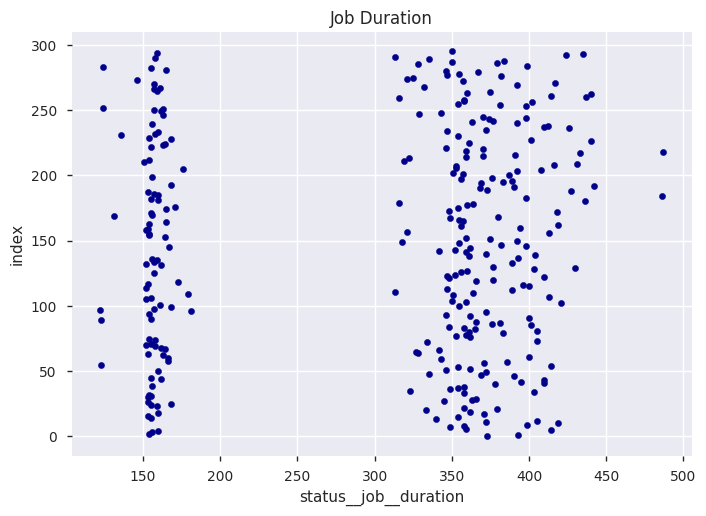

In [31]:
s_plot = df_duration.plot.scatter(x='status__job__duration',y = 'index', c='DarkBlue', title = 'Job Duration')

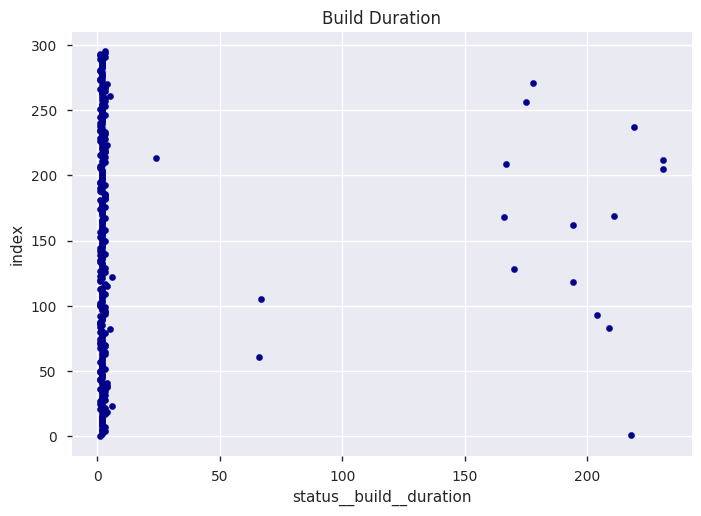

In [32]:
s_plot = df_duration.plot.scatter(x='status__build__duration',y = 'index', c='DarkBlue', title = 'Build Duration')

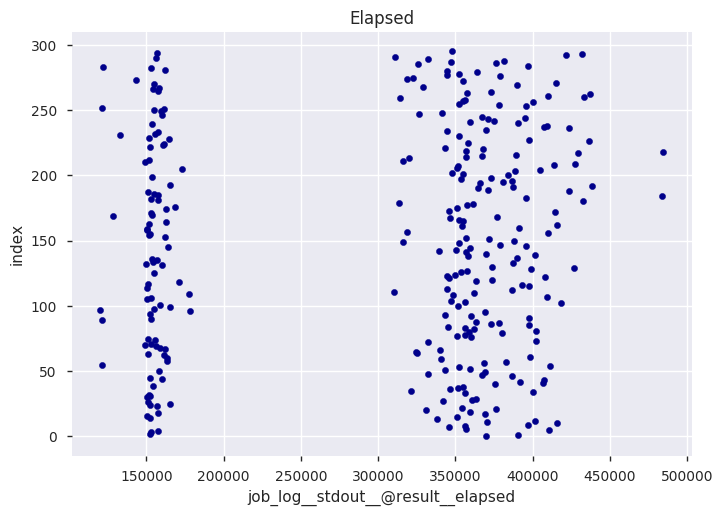

In [33]:
s_plot = df_duration.plot.scatter(x='job_log__stdout__@result__elapsed',y = 'index', c='DarkBlue', title = 'Elapsed')

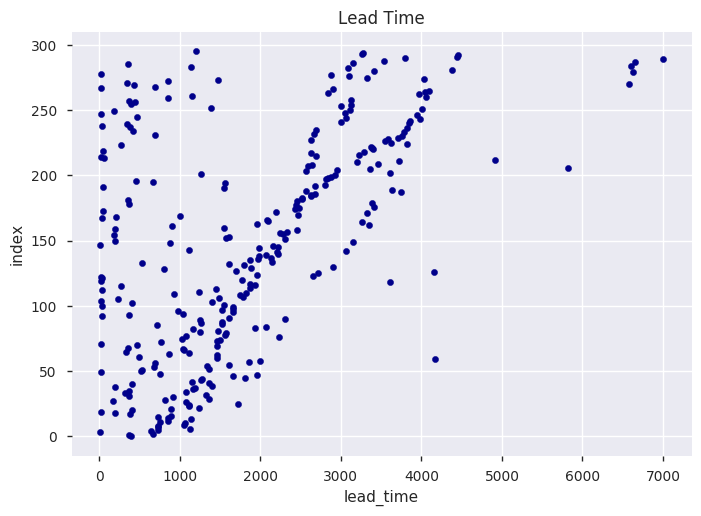

In [34]:
s_plot = df_duration.plot.scatter(x='lead_time',y = 'index', c='DarkBlue', title = 'Lead Time')

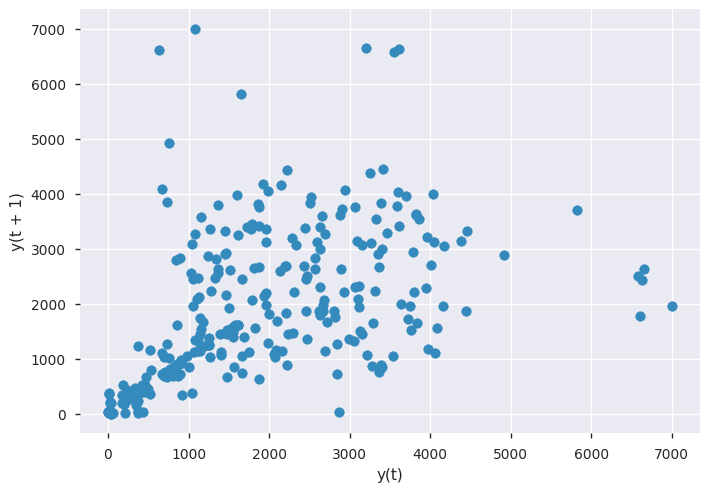

In [35]:
df = df_duration.sort_values(by=["created"])
lag_plot(df["lead_time"])

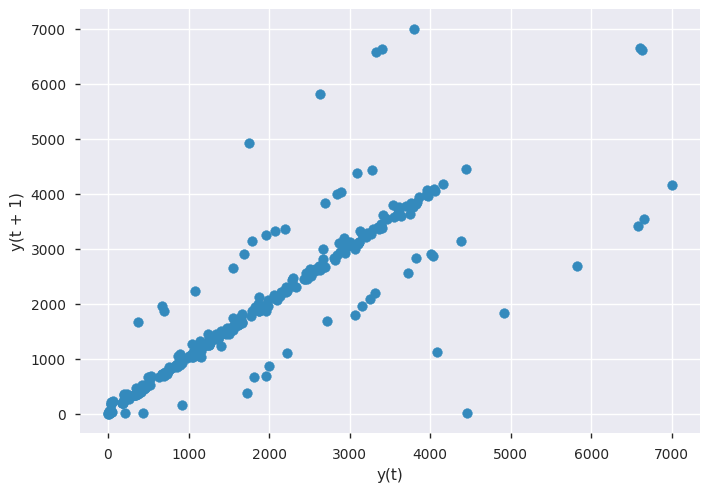

In [36]:
df = df_duration.sort_values(by=["status__job__started_at"])
lag_plot(df["lead_time"])

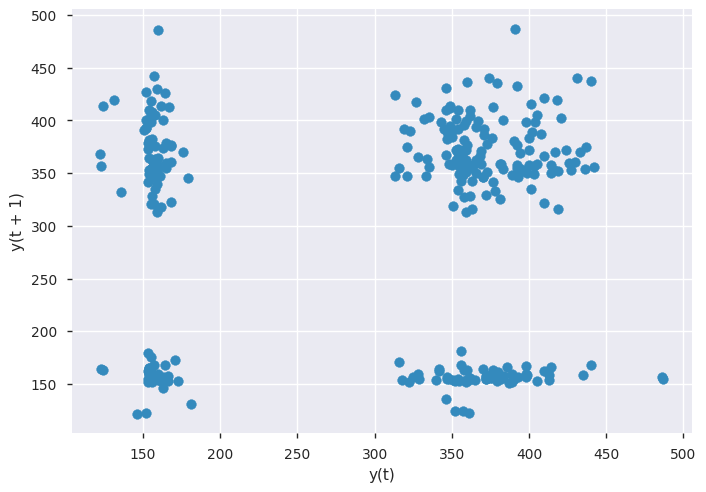

In [37]:
df = df_duration.sort_values(by=["status__job__started_at"])
lag_plot(df["status__job__duration"])

## Behavior of categorical data through the cluster <a name="seperate-left-and-right"></a>

In [38]:
#Come up with a function here that could automatically split the clusters by ncpus
df_left = df_duration[df_duration['status__job__duration'] < 250]
df_right = df_duration[df_duration['status__job__duration'] > 250]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


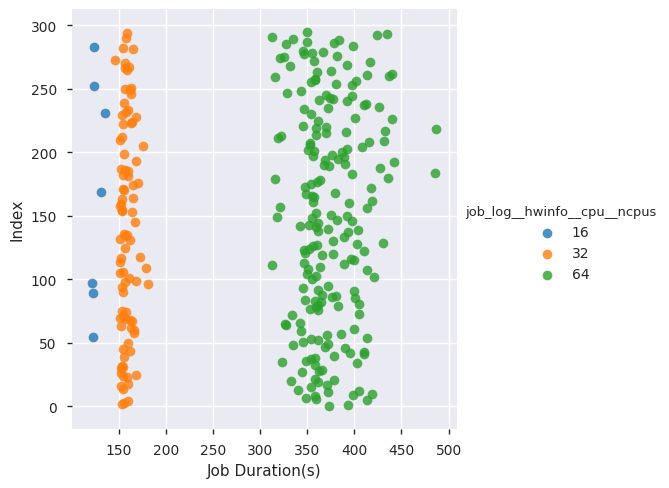

In [39]:
g = sns.lmplot( x="status__job__duration", y="index", data=df, fit_reg=False, hue='job_log__hwinfo__cpu__ncpus', legend=True)
g.set_axis_labels("Job Duration(s)", "Index")

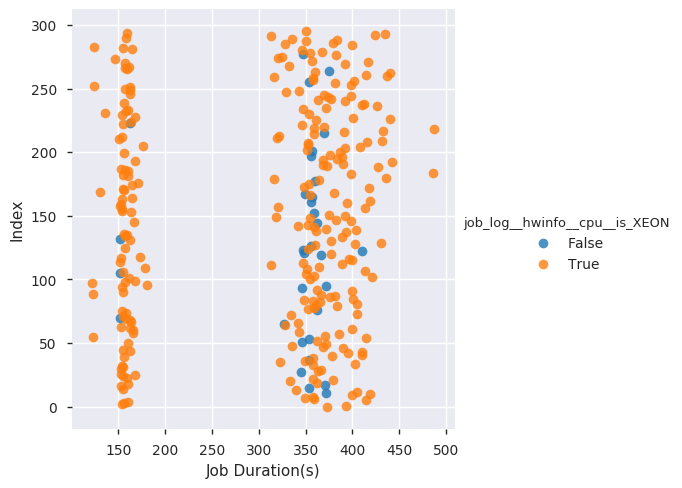

In [40]:
h = sns.lmplot( x="status__job__duration", y="index", data=df, fit_reg=False, hue='job_log__hwinfo__cpu__is_XEON', legend=True)
h.set_axis_labels("Job Duration(s)", "Index")

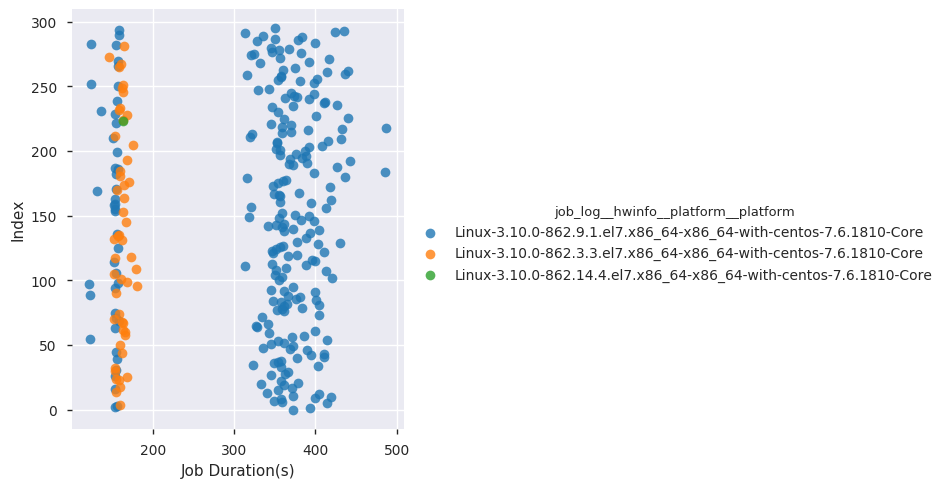

In [41]:
i = sns.lmplot( x="status__job__duration", y="index", data=df, fit_reg=False, hue='job_log__hwinfo__platform__platform', legend=True)
i.set_axis_labels("Job Duration(s)", "Index")

In [42]:
columns_to_analyze = [ "created", "status__build__started_at", "status__build__finished_at", 
                     "status__job__started_at", "status__job__finished_at","job_log__stdout__@result__rate", 
                     "job_log__stdout__@result__elapsed", "status__build__duration", "status__job__duration", 
                      "job_log__hwinfo__cpu__is_XEON", "job_log__hwinfo__cpu__ncpus", 
                      "job_log__hwinfo__platform__platform"]
df_duration['job_log__stdout__@result__elapsed'] = df_duration['job_log__stdout__@result__elapsed'].apply(lambda x: x*.001)

In [43]:
df_analyze = df_duration[columns_to_analyze]

In [44]:
df_analyze

created status__build__started_at  \
0   2019-05-10 12:25:54.606897 2019-05-10 12:32:23+00:00   
1   2019-05-10 03:07:00.369512 2019-05-10 03:07:04+00:00   
2   2019-05-10 12:26:50.010847 2019-05-10 12:37:25+00:00   
3   2019-05-10 12:25:46.359680 2019-05-10 12:25:50+00:00   
4   2019-05-10 12:26:58.437661 2019-05-10 12:37:27+00:00   
5   2019-05-10 12:26:22.312520 2019-05-10 12:38:26+00:00   
6   2019-05-10 13:18:45.882777 2019-05-10 13:37:28+00:00   
7   2019-05-10 12:26:26.600640 2019-05-10 12:38:28+00:00   
8   2019-05-10 12:26:49.472458 2019-05-10 12:38:53+00:00   
9   2019-05-10 13:20:06.598433 2019-05-10 13:37:29+00:00   
10  2019-05-10 03:23:03.302368 2019-05-10 03:40:15+00:00   
11  2019-05-10 12:26:27.822241 2019-05-10 12:38:52+00:00   
12  2019-05-10 12:26:51.370719 2019-05-10 12:40:23+00:00   
13  2019-05-10 13:19:14.876506 2019-05-10 13:37:44+00:00   
14  2019-05-10 12:26:20.347255 2019-05-10 12:40:24+00:00   
15  2019-05-10 03:07:15.131973 2019-05-10 03:17:48+00:00   
16  2019-05-10 12:26:26.598778 2019-05-10 12:41:14+00:00   
17  2019-05-10 11:47:01.916735 2019-05-10 11:52:53+00:00   
18  2019-05-10 11:46:42.288707 2019-05-10 11:49:31+00:00   
19  2019-05-10 03:07:03.917210 2019-05-10 03:07:09+00:00   
20  2019-05-10 12:25:53.193830 2019-05-10 12:32:22+00:00   
21  2019-05-10 12:26:48.108040 2019-05-10 12:41:15+00:00   
22  2019-05-10 03:23:05.688034 2019-05-10 03:42:26+00:00   
23  2019-05-10 13:19:16.664556 2019-05-10 13:37:44+00:00   
24  2019-05-10 12:26:08.588328 2019-05-10 12:44:03+00:00   
25  2019-05-10 03:26:23.429890 2019-05-10 03:54:44+00:00   
26  2019-05-10 12:26:32.307483 2019-05-10 12:44:01+00:00   
27  2019-05-10 03:22:54.610353 2019-05-10 03:24:55+00:00   
28  2019-05-10 03:07:17.463240 2019-05-10 03:19:50+00:00   
29  2019-05-10 13:19:11.316982 2019-05-10 13:40:40+00:00   
30  2019-05-10 03:07:20.267543 2019-05-10 03:21:21+00:00   
31  2019-05-10 12:25:51.823206 2019-05-10 12:31:52+00:00   
32  2019-05-10 13:18:53.777758 2019-05-10 13:40:45+00:00   
33  2019-05-10 03:22:56.832850 2019-05-10 03:27:07+00:00   
34  2019-05-10 12:27:15.314988 2019-05-10 12:45:07+00:00   
35  2019-05-10 03:49:00.241347 2019-05-10 03:54:44+00:00   
36  2019-05-10 12:25:57.080159 2019-05-10 12:33:30+00:00   
37  2019-05-10 12:26:21.460966 2019-05-10 12:45:43+00:00   
38  2019-05-10 03:22:55.365061 2019-05-10 03:25:40+00:00   
39  2019-05-10 13:18:43.344641 2019-05-10 13:41:19+00:00   
40  2019-05-10 12:25:52.766671 2019-05-10 12:32:24+00:00   
41  2019-05-10 13:19:07.058724 2019-05-10 13:41:19+00:00   
42  2019-05-10 12:26:44.981103 2019-05-10 12:45:43+00:00   
43  2019-05-10 12:26:26.983945 2019-05-10 12:47:29+00:00   
44  2019-05-10 12:26:38.950184 2019-05-10 12:47:29+00:00   
45  2019-05-10 03:26:36.928203 2019-05-10 03:55:40+00:00   
46  2019-05-10 03:28:07.199309 2019-05-10 03:55:40+00:00   
47  2019-05-10 03:24:26.633120 2019-05-10 03:56:35+00:00   
48  2019-05-10 03:23:00.781448 2019-05-10 03:34:31+00:00   
49  2019-05-10 11:46:25.978984 2019-05-10 11:46:30+00:00   
50  2019-05-10 12:25:56.968844 2019-05-10 12:33:28+00:00   
51  2019-05-10 03:22:58.314176 2019-05-10 03:30:08+00:00   
52  2019-05-10 13:19:17.511281 2019-05-10 13:41:35+00:00   
53  2019-05-10 03:45:29.767991 2019-05-10 03:56:36+00:00   
54  2019-05-10 12:26:32.847523 2019-05-10 12:48:09+00:00   
55  2019-05-10 03:24:24.101152 2019-05-10 03:51:08+00:00   
56  2019-05-10 03:45:38.908417 2019-05-10 03:56:51+00:00   
57  2019-05-10 03:26:27.274485 2019-05-10 03:56:51+00:00   
58  2019-05-10 03:26:36.867823 2019-05-10 03:59:27+00:00   
59  2019-05-10 13:18:52.485954 2019-05-10 13:41:34+00:00   
60  2019-05-10 12:26:42.350650 2019-05-10 12:50:56+00:00   
61  2019-05-10 03:07:11.517159 2019-05-10 03:13:35+00:00   
62  2019-05-10 03:23:33.817995 2019-05-10 03:47:41+00:00   
63  2019-05-10 03:45:37.935894 2019-05-10 03:59:29+00:00   
64  2019-05-10 03:45:30.799034 2019-05-10 04:02:24+00:00   
65  2019-05-10 03:22:57.280190 2019-05-10 03:28:02+00:00   
66 

In [45]:
df_left = df_analyze[df_analyze['status__job__duration'] < 250]
df_right = df_analyze[df_analyze['status__job__duration'] > 250]

In [46]:
len(df_left)

96

In [47]:
len(df_right)

200

In [48]:
py.iplot(inspection.create_duration_histogram(df_left, ["status__job__duration"]))

In [49]:
py.iplot(inspection.create_duration_histogram(df_right, ["status__job__duration"]))

## Further analysis <a name="descriptive-analysis"></a>

In [50]:
#Have measures of normality here after splitting the data by each categorical parameter

**Elapsed**

In [51]:
df_analyze["job_log__stdout__@result__elapsed"].describe()

count    296.000000
mean     300.761476
std      105.028556
min      119.850403
25%      160.435956
50%      351.683826
75%      376.688536
max      484.622079
Name: job_log__stdout__@result__elapsed, dtype: float64

In [52]:
df_left["job_log__stdout__@result__elapsed"].describe()

count     96.000000
mean     154.275528
std       10.511997
min      119.850403
25%      151.902867
50%      154.289465
75%      159.571100
max      178.446759
Name: job_log__stdout__@result__elapsed, dtype: float64

In [53]:
df_right["job_log__stdout__@result__elapsed"].describe()

count    200.000000
mean     371.074731
std       31.293318
min      310.161917
25%      351.344139
50%      364.410660
75%      392.504197
max      484.622079
Name: job_log__stdout__@result__elapsed, dtype: float64

**Build Duration**

In [54]:
df_analyze["status__build__duration"].describe()

count    296.000000
mean      11.827703
std       42.119451
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max      231.000000
Name: status__build__duration, dtype: float64

In [55]:
df_left["status__build__duration"].describe()

count     96.000000
mean      11.802083
std       43.588656
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max      231.000000
Name: status__build__duration, dtype: float64

In [56]:
df_right["status__build__duration"].describe()

count    200.000000
mean      11.840000
std       41.507212
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max      219.000000
Name: status__build__duration, dtype: float64

**Job Duration**

In [57]:
df_analyze["status__job__duration"].describe()

count    296.000000
mean     303.206081
std      105.214461
min      122.000000
25%      162.750000
50%      354.000000
75%      379.250000
max      487.000000
Name: status__job__duration, dtype: float64

In [58]:
df_left["status__job__duration"].describe()

count     96.000000
mean     156.510417
std       10.583995
min      122.000000
25%      154.000000
50%      157.000000
75%      162.000000
max      181.000000
Name: status__job__duration, dtype: float64

In [59]:
df_right["status__job__duration"].describe()

count    200.000000
mean     373.620000
std       31.505373
min      313.000000
25%      353.750000
50%      367.500000
75%      395.250000
max      487.000000
Name: status__job__duration, dtype: float64

**Difference between the elapsed and job duration**

In [60]:
(df_analyze["status__job__duration"] - df_analyze["job_log__stdout__@result__elapsed"]).describe()

count    296.000000
mean       2.444605
std        0.528684
min        1.301028
25%        2.033681
50%        2.430507
75%        2.780683
max        3.956015
dtype: float64

In [61]:
(df_left["status__job__duration"] - df_left["job_log__stdout__@result__elapsed"]).describe()

count    96.000000
mean      2.234888
std       0.433345
min       1.357988
25%       1.839633
50%       2.258989
75%       2.537480
max       3.245371
dtype: float64

In [62]:
(df_right["status__job__duration"] - df_right["job_log__stdout__@result__elapsed"]).describe()

count    200.000000
mean       2.545269
std        0.541568
min        1.301028
25%        2.133902
50%        2.523004
75%        2.925377
max        3.956015
dtype: float64

**Correlations within the left cluster**

In [63]:
df_left.corr(method ='pearson') 

job_log__stdout__@result__rate  \
job_log__stdout__@result__rate                           1.000000   
job_log__stdout__@result__elapsed                       -0.991601   
status__build__duration                                 -0.003654   
status__job__duration                                   -0.990335   
job_log__hwinfo__cpu__is_XEON                           -0.019051   
job_log__hwinfo__cpu__ncpus                             -0.873486   

                                   job_log__stdout__@result__elapsed  \
job_log__stdout__@result__rate                             -0.991601   
job_log__stdout__@result__elapsed                           1.000000   
status__build__duration                                     0.029801   
status__job__duration                                       0.999179   
job_log__hwinfo__cpu__is_XEON                               0.034491   
job_log__hwinfo__cpu__ncpus                                 0.814448   

                                   status__build__duration  \
job_log__stdout__@result__rate                   -0.003654   
job_log__stdout__@result__elapsed                 0.029801   
status__build__duration                           1.000000   
status__job__duration                             0.034195   
job_log__hwinfo__cpu__is_XEON                    -0.034613   
job_log__hwinfo__cpu__ncpus                      -0.129711   

                                   status__job__duration  \
job_log__stdout__@result__rate                 -0.990335   
job_log__stdout__@result__elapsed               0.999179   
status__build__duration                         0.034195   
status__job__duration                           1.000000   
job_log__hwinfo__cpu__is_XEON                   0.034864   
job_log__hwinfo__cpu__ncpus                     0.808887   

                                   job_log__hwinfo__cpu__is_XEON  \
job_log__stdout__@result__rate                         -0.019051   
job_log__stdout__@result__elapsed                       0.034491   
status__build__duration                                -0.034613   
status__job__duration                                   0.034864   
job_log__hwinfo__cpu__is_XEON                           1.000000   
job_log__hwinfo__cpu__ncpus                            -0.058478   

                                   job_log__hwinfo__cpu__ncpus  
job_log__stdout__@result__rate                       -0.873486  
job_log__stdout__@result__elapsed                     0.814448  
status__build__duration                              -0.129711  
status__job__duration                                 0.808887  
job_log__hwinfo__cpu__is_XEON                        -0.058478  
job_log__hwinfo__cpu__ncpus                           1.000000

In [64]:
df_right.corr(method = 'pearson')

job_log__stdout__@result__rate  \
job_log__stdout__@result__rate                           1.000000   
job_log__stdout__@result__elapsed                       -0.993213   
status__build__duration                                 -0.159052   
status__job__duration                                   -0.993146   
job_log__hwinfo__cpu__is_XEON                           -0.182227   
job_log__hwinfo__cpu__ncpus                                   NaN   

                                   job_log__stdout__@result__elapsed  \
job_log__stdout__@result__rate                             -0.993213   
job_log__stdout__@result__elapsed                           1.000000   
status__build__duration                                     0.157291   
status__job__duration                                       0.999874   
job_log__hwinfo__cpu__is_XEON                               0.194709   
job_log__hwinfo__cpu__ncpus                                      NaN   

                                   status__build__duration  \
job_log__stdout__@result__rate                   -0.159052   
job_log__stdout__@result__elapsed                 0.157291   
status__build__duration                           1.000000   
status__job__duration                             0.156940   
job_log__hwinfo__cpu__is_XEON                     0.023847   
job_log__hwinfo__cpu__ncpus                            NaN   

                                   status__job__duration  \
job_log__stdout__@result__rate                 -0.993146   
job_log__stdout__@result__elapsed               0.999874   
status__build__duration                         0.156940   
status__job__duration                           1.000000   
job_log__hwinfo__cpu__is_XEON                   0.196871   
job_log__hwinfo__cpu__ncpus                          NaN   

                                   job_log__hwinfo__cpu__is_XEON  \
job_log__stdout__@result__rate                         -0.182227   
job_log__stdout__@result__elapsed                       0.194709   
status__build__duration                                 0.023847   
status__job__duration                                   0.196871   
job_log__hwinfo__cpu__is_XEON                           1.000000   
job_log__hwinfo__cpu__ncpus                                  NaN   

                                   job_log__hwinfo__cpu__ncpus  
job_log__stdout__@result__rate                             NaN  
job_log__stdout__@result__elapsed                          NaN  
status__build__duration                                    NaN  
status__job__duration                                      NaN  
job_log__hwinfo__cpu__is_XEON                              NaN  
job_log__hwinfo__cpu__ncpus                                NaN